In [88]:
import os
import random
import numpy as np
import cv2
import torch
import csv
import re
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


In [89]:
DATA_DIR = './training/' 

IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'groundtruth')

# Training settings
ENCODER = 'mobilenet_v2'  # Lightweight backbone, fast for CPU
PRETRAINED = 'imagenet'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 100  # Number of training rounds. Start with a smaller number (5-10) to see how long it takes.
BATCH_SIZE = 4 # How many images to process at once. Keep this low for CPU training.
LEARNING_RATE = 0.001
IMG_SIZE = 200 # Resize images to this size for consistent training

In [90]:
def get_training_augmentations(img_size):
    """
    Returns a set of heavy augmentations for the training data.
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=35, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_validation_augmentations(img_size):
    """
    Returns a minimal set of augmentations for validation (just resizing and normalization).
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [91]:
# 4. Custom PyTorch Dataset
#
# This class is responsible for loading your images and masks from the disk
# and applying the augmentations we defined above.

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augmentations=None):
        self.image_ids = sorted(os.listdir(image_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        mask_path = os.path.join(self.mask_dir, image_id)

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            # Add a channel dimension to the mask for the loss function
            mask = mask.unsqueeze(0)

        return image, mask

In [92]:
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=PRETRAINED,
    in_channels=3,
    classes=1,  # We are segmenting one class: road
    activation='sigmoid' # Sigmoid is used for binary segmentation
)

In [93]:
from segmentation_models_pytorch.utils import metrics
from segmentation_models_pytorch.utils import train
# A good loss function for segmentation is a combination of Dice and BCE
loss_fn = smp.losses.DiceLoss(mode='binary')
loss_fn.__name__ = 'DiceLoss'

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Metrics help us evaluate the model's performance
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]


In [94]:
# Get all image ids
all_image_ids = sorted(os.listdir(IMAGE_DIR))
random.seed(42) # for reproducibility
random.shuffle(all_image_ids)

# Split into train and validation sets
train_size = int(0.8 * len(all_image_ids))
train_ids = all_image_ids[:train_size]
valid_ids = all_image_ids[train_size:]

# Create temporary directories for the split
temp_train_img_dir = 'temp_train/images'
temp_train_mask_dir = 'temp_train/masks'
temp_valid_img_dir = 'temp_valid/images'
temp_valid_mask_dir = 'temp_valid/masks'

os.makedirs(temp_train_img_dir, exist_ok=True)
os.makedirs(temp_train_mask_dir, exist_ok=True)
os.makedirs(temp_valid_img_dir, exist_ok=True)
os.makedirs(temp_valid_mask_dir, exist_ok=True)

# Copy files to temporary directories
import shutil
for img_id in train_ids:
    shutil.copy(os.path.join(IMAGE_DIR, img_id), os.path.join(temp_train_img_dir, img_id))
    shutil.copy(os.path.join(MASK_DIR, img_id), os.path.join(temp_train_mask_dir, img_id))
for img_id in valid_ids:
    shutil.copy(os.path.join(IMAGE_DIR, img_id), os.path.join(temp_valid_img_dir, img_id))
    shutil.copy(os.path.join(MASK_DIR, img_id), os.path.join(temp_valid_mask_dir, img_id))


# Create Dataset and DataLoader instances
train_dataset = RoadDataset(temp_train_img_dir, temp_train_mask_dir, augmentations=get_training_augmentations(IMG_SIZE))
valid_dataset = RoadDataset(temp_valid_img_dir, temp_valid_mask_dir, augmentations=get_validation_augmentations(IMG_SIZE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False) # Batch size 1 for validation


In [95]:
# 8. Train the Model
#
# This is the main training loop. It will iterate through your data for the
# number of epochs you defined.

# UPDATED: Import the training epoch runners directly
from segmentation_models_pytorch.utils import train

train_epoch = train.TrainEpoch(
    model,
    loss=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = train.ValidEpoch(
    model,
    loss=loss_fn,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

max_iou_score = 0
max_fscore = 0
best_model_path = 'best_model.pth'

for i in range(EPOCHS):
    print(f'\nEpoch: {i+1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Save the model if it has the best IoU score so far
    if valid_logs['fscore'] > max_fscore:
        max_fscore = valid_logs['fscore']
        torch.save(model, best_model_path)
        print(f"Model saved! Best f1 score: {max_fscore:.4f}")


Epoch: 1
valid: 100%|██████████| 20/20 [00:00<00:00, 23.23it/s, DiceLoss - 0.6879, iou_score - 0.2091, fscore - 0.3376]
Model saved! Best f1 score: 0.3376

Epoch: 2
valid: 100%|██████████| 20/20 [00:00<00:00, 22.47it/s, DiceLoss - 0.6609, iou_score - 0.3792, fscore - 0.5294]
Model saved! Best f1 score: 0.5294

Epoch: 3
valid: 100%|██████████| 20/20 [00:00<00:00, 22.75it/s, DiceLoss - 0.6555, iou_score - 0.4021, fscore - 0.5534]
Model saved! Best f1 score: 0.5534

Epoch: 4
valid: 100%|██████████| 20/20 [00:00<00:00, 22.38it/s, DiceLoss - 0.6496, iou_score - 0.4511, fscore - 0.5983]
Model saved! Best f1 score: 0.5983

Epoch: 5
valid: 100%|██████████| 20/20 [00:00<00:00, 22.03it/s, DiceLoss - 0.6457, iou_score - 0.5003, fscore - 0.6412]
Model saved! Best f1 score: 0.6412

Epoch: 6
valid: 100%|██████████| 20/20 [00:00<00:00, 22.68it/s, DiceLoss - 0.6439, iou_score - 0.4889, fscore - 0.6293]

Epoch: 7
valid: 100%|██████████| 20/20 [00:00<00:00, 22.65it/s, DiceLoss - 0.6433, iou_score - 0.5

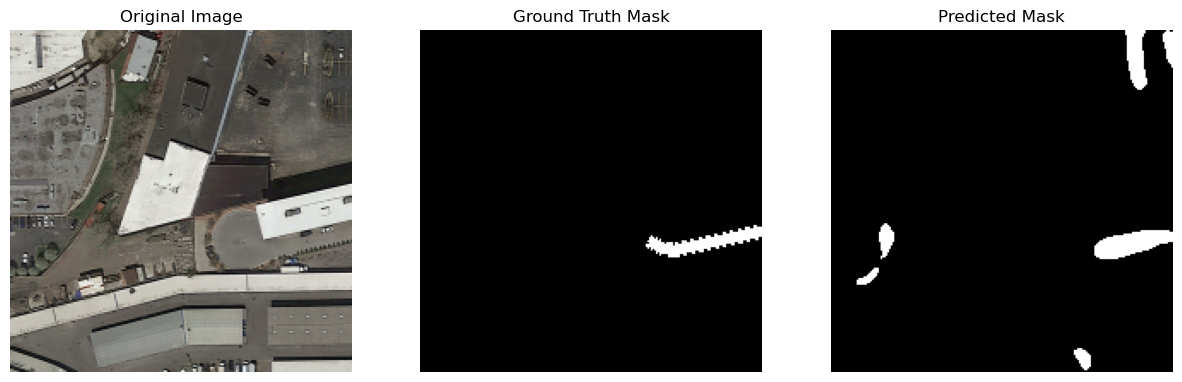

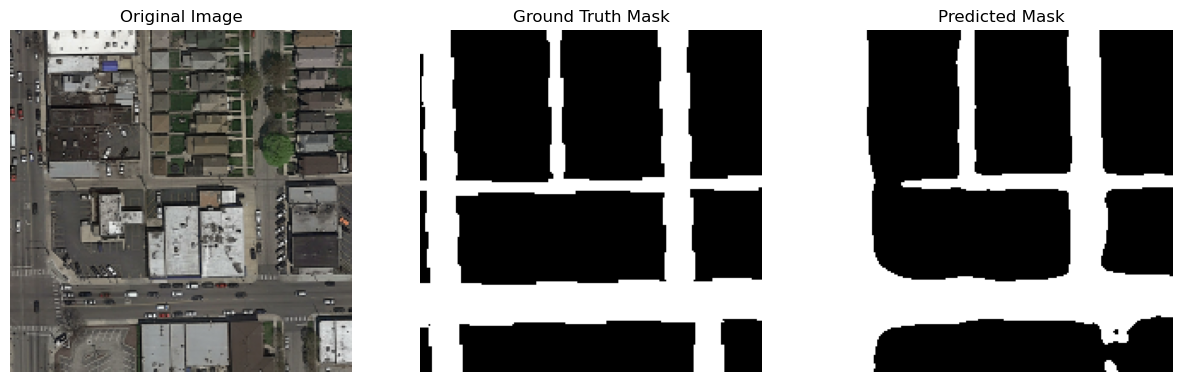

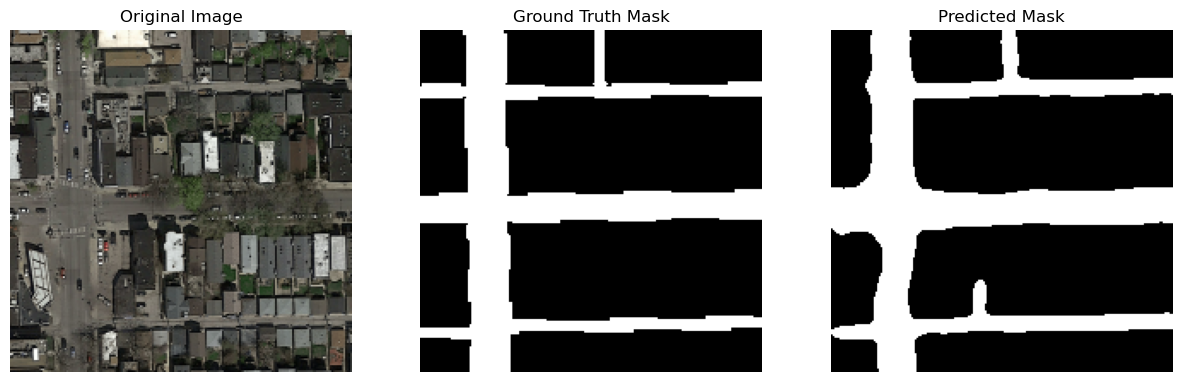

In [96]:
# 9. Visualize Results
#
# Let's see how our trained model performs on a few images from the
# validation set.

# Load the best model, explicitly setting weights_only=False because we saved the entire model object and not just the weights. This is safe because we trust the file we just created.
best_model = torch.load(best_model_path, weights_only=False)

best_model.to(DEVICE)
best_model.eval()

# Helper function for visualization
def visualize_prediction(image, ground_truth_mask, predicted_mask):
    """Plots original image, ground truth, and predicted mask."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

# Run prediction on a few random validation images
num_visualize = 3
for i in range(num_visualize):
    # Get a random image from the validation set
    idx = random.randint(0, len(valid_dataset) - 1)
    image, gt_mask = valid_dataset[idx]

    # The dataloader gives us a tensor, for visualization we need to
    # process it back to a viewable format.
    original_image = image.permute(1, 2, 0).numpy() # from (C, H, W) to (H, W, C)
    # Undo normalization for viewing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original_image = std * original_image + mean
    original_image = np.clip(original_image, 0, 1)

    gt_mask = gt_mask.squeeze().numpy() # from (1, H, W) to (H, W)

    # Predict
    with torch.no_grad():
        # Add batch dimension and send to device
        input_tensor = image.unsqueeze(0).to(DEVICE)
        pred_mask = best_model(input_tensor)
        pred_mask = pred_mask.squeeze().cpu().numpy()
        # Apply threshold to get binary mask
        pred_mask = (pred_mask > 0.5).astype(float)

    visualize_prediction(original_image, gt_mask, pred_mask)

In [7]:
import torch
# --- Define Constants ---
TEST_IMAGE_DIR = './test_set_images/'
SUBMISSION_FILENAME = 'submission.csv'
PATCH_SIZE = 16
FOREGROUND_THRESHOLD = 0.25

# --- Load the Best Model ---
print("Loading best model for submission...")
best_model = torch.load(best_model_path, map_location=torch.device(DEVICE), weights_only=False)
best_model.to(DEVICE)
best_model.eval()
print("Model loaded.")


# --- Define transformations for test images ---
# Pad images to a size divisible by the U-Net encoder's downsampling factor (32)
test_transform = A.Compose([
    A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# --- Helper function to classify a 16x16 patch ---
def patch_to_label(patch, threshold):
    """Assigns a label based on the proportion of foreground pixels in the patch."""
    foreground_percentage = np.mean(patch)
    return 1 if foreground_percentage > threshold else 0

# --- Generate Submission File ---
# --- MODIFIED: Use os.walk to find images in subdirectories ---
test_image_paths = []
for root, dirs, files in os.walk(TEST_IMAGE_DIR):
    for file in files:
        if file.endswith('.png'):
            test_image_paths.append(os.path.join(root, file))
test_image_paths.sort() # Sort to ensure a consistent order

print(f"\nFound {len(test_image_paths)} test images. Generating submission file...")

with open(SUBMISSION_FILENAME, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'prediction'])

    for image_path in tqdm(test_image_paths, desc="Creating Submission"):
        # --- MODIFIED: Extract image number from the parent directory name ---
        parent_dir_name = os.path.basename(os.path.dirname(image_path)) # e.g., 'test_1'
        img_number_match = re.search(r'(\d+)', parent_dir_name)
        if not img_number_match:
            continue
        img_number = int(img_number_match.group(1))

        # Load and preprocess the test image
        image = cv2.imread(image_path)
        original_h, original_w, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transformed = test_transform(image=image)
        input_tensor = transformed['image'].unsqueeze(0).to(DEVICE)

        # Predict a full mask with the U-Net
        with torch.no_grad():
            pred_mask = best_model(input_tensor)
            pred_mask_padded = pred_mask.squeeze().cpu().numpy()
            pred_mask_unpadded = pred_mask_padded[:original_h, :original_w]

        binary_mask = (pred_mask_unpadded > 0.5).astype(np.uint8)

        # Iterate over the unpadded mask in 16x16 patches
        for y in range(0, original_h, PATCH_SIZE):
            for x in range(0, original_w, PATCH_SIZE):
                patch = binary_mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                label = patch_to_label(patch, FOREGROUND_THRESHOLD)
                
                submission_id = "{:03d}_{}_{}".format(img_number, y, x)
                writer.writerow([submission_id, label])

print(f"\n--- Submission file '{SUBMISSION_FILENAME}' created successfully! ---")

Loading best model for submission...


NameError: name 'best_model_path' is not defined

In [8]:
import random
import torch
from matplotlib.patches import Patch

# --- Define Constants for Visualization ---
NUM_VISUALIZE = 3 # How many test images to display

# --- Load the Best Model ---
# This section should match the loading method in your submission script.
# This assumes you are loading a state_dict.
print("Loading best model for visualization...")
best_model = torch.load(best_model_path, weights_only=False)
best_model.to(DEVICE)
best_model.eval()
print("Model loaded.")

# --- Get Test Image Paths ---
# Using the same os.walk logic as the submission script
test_image_paths = []
for root, dirs, files in os.walk(TEST_IMAGE_DIR):
    for file in files:
        if file.endswith('.png'):
            test_image_paths.append(os.path.join(root, file))
random.shuffle(test_image_paths) # Shuffle to get random images each time

# --- Create plots for a few random test images ---
for i in range(NUM_VISUALIZE):
    image_path = test_image_paths[i]
    
    # Load the raw image for display and transformations
    # Keep the original BGR image for overlay creation with OpenCV
    raw_image_bgr = cv2.imread(image_path)
    # Convert to RGB for matplotlib display
    raw_image_rgb = cv2.cvtColor(raw_image_bgr, cv2.COLOR_BGR2RGB)
    
    original_h, original_w, _ = raw_image_bgr.shape

    # Preprocess the image (same as in the submission script)
    transformed = test_transform(image=raw_image_rgb)
    input_tensor = transformed['image'].unsqueeze(0).to(DEVICE)

    # Predict the mask
    with torch.no_grad():
        pred_mask_padded = best_model(input_tensor).squeeze().cpu().numpy()
        pred_mask_unpadded = pred_mask_padded[:original_h, :original_w]
        binary_mask = (pred_mask_unpadded > 0.5).astype(np.uint8)

    # --- Create the Overlay Image ---
    # Create a green color mask for the predicted road areas
    overlay_mask = np.zeros_like(raw_image_rgb)
    overlay_mask[binary_mask == 1] = [0, 255, 0] # Green for road

    # Blend the original image and the color mask
    # The overlay will have roads highlighted in semi-transparent green
    overlayed_image = cv2.addWeighted(raw_image_rgb, 1, overlay_mask, 0.4, 0)

    # --- Plotting ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
    
    ax1.imshow(raw_image_rgb)
    ax1.set_title(f"Raw Test Image:\n{os.path.basename(image_path)}")
    ax1.axis("off")

    ax2.imshow(binary_mask, cmap='gray')
    ax2.set_title("Predicted Mask")
    ax2.axis("off")

    ax3.imshow(overlayed_image)
    ax3.set_title("Prediction Overlay")
    ax3.axis("off")

    # Create a custom legend for the overlay
    legend_patches = [Patch(color='green', label='Predicted Road')]
    ax3.legend(handles=legend_patches, loc='lower right', frameon=True)

    plt.tight_layout()
    plt.show()

Loading best model for visualization...


NameError: name 'best_model_path' is not defined